In [9]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from code import inverse_problem as inv 
from code import direct_problem as direct 

In [10]:
r=np.logspace(-1,3,50)
param=[50,20,
       100,5,1,5,100,5,1,5,100,5,1,5,100,5,1,5,100,5,1,5,
       200]
method='U'

resistance=[]
for r_i in r:
    resistance.append(direct.calculate_apparent_resistance(param,method,r_i,10*int(1+r_i/200))) 

In [11]:
start=[[50,40,
       10,100,
       200]]


bound=[[(25,75), (10,50),
       (1,25), (50,1000),
       (100,250)]]

15.33416182097697
41.51810011946377 %


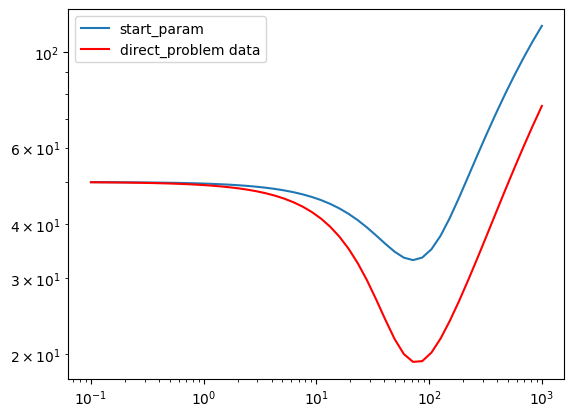

In [12]:
rk_start=[]
for r_i in r:
    rk_start.append(direct.calculate_apparent_resistance(start[0],method,r_i,num_of_zeros=10*int(1+r_i/200)))
rk_start=np.array(rk_start)
plt.loglog(r,rk_start, label='start_param')
plt.loglog(r,resistance,c='red', label='direct_problem data')
plt.legend()
print(inv.RMSE(rk_start,resistance))
print(inv.RMSPE(rk_start,resistance),'%')

In [13]:
N_layers_list=[3]
loss='RMSPE'
minim='L-BFGS-B'
inverse=inv.inverse_problem_solver(N_layers_list,method, np.array([r,resistance]).T, minimization_method=minim, loss_type=loss, start=start,boundaries=bound) 
results=inverse[0] # модели полученные из обратной задачи 
ind=inverse[1] #  индекс модели с наименьшим loss_N_layers в results
print(ind)

0


In [14]:
#Вывод количества слоёв в модели, её параметров и полученной ошибки
t=''
if loss=="RMSPE": t='%'

for i in range (len(N_layers_list)):
    print('\nnumber of layers= ', N_layers_list[i], '\nparam =', results[i].x, f'\nloss {loss} =', results[i].fun,t)


number of layers=  3 
param = [ 50.10013778  28.14683292   8.52547341 203.50685035 186.5955754 ] 
loss RMSPE = 0.3668897784949851 %


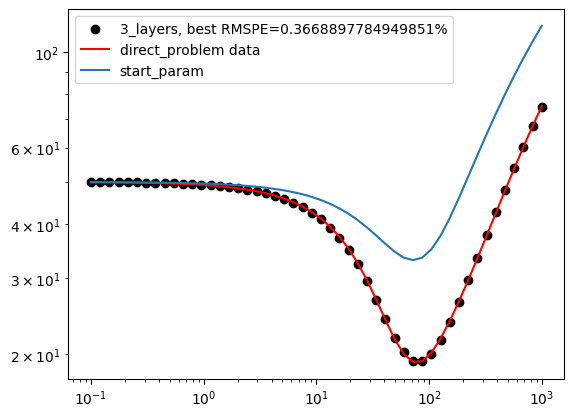

In [15]:
# Визуализация
for i in range(len(N_layers_list)):
    rk=[]
    for r_i in r:
        rk.append(direct.calculate_apparent_resistance(results[i].x,method,r_i,num_of_zeros=10*int(1+r_i/200)))
    rk=np.array(rk)
    if i==ind:
        plt.scatter(r,rk, c='black',label=f'{N_layers_list[i]}_layers, best {loss}={results[i].fun}{t}')
    else: plt.loglog(r,rk, label=f'{N_layers_list[i]}_layers')
plt.loglog(r,resistance,c='red', label='direct_problem data')
plt.loglog(r,rk_start, label='start_param')
plt.legend()

In [16]:
results[0].x

array([ 50.10013778,  28.14683292,   8.52547341, 203.50685035,
       186.5955754 ])